# Tree decisions:

- Combine neural ridge with epidermal 
- Combine adaxial cells with PSM
- Combine dorsal margin, dorsal margin involuted, dorsal margin anterior
- Combine non-dorsal margin, non-dorsal margin involuted


# Set up

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
import scanpy as sc
import scanpy.external as sce
import os
import scipy.sparse as ssp
import sys
import pickle
import scipy.stats as ss

# !!!!
# Change this path to point to folder containing helper_functions.py
sys.path.append('/Users/kalki/Dropbox (HMS)/PhD_lab/SPRING_dev/data_prep/')
import helper_functions_py3 as hf
import seaborn as sn
from collections import Counter
#from adjustText import adjust_text

sc.settings.verbosity = 2  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=150)  # low dpi (dots per inch) yields small inline figures


# Load data

In [2]:
# load Wagner et al reference data and subset it into time points:

adata_dan = sc.read('/Users/kalki/Dropbox (HMS)/PhD_lab/0.projects/cell_cycle/Dan_zfish_data_new/adata_dan.h5ad')

adata14_dan = adata_dan[adata_dan.obs.time_point == 14]
adata18_dan = adata_dan[adata_dan.obs.time_point == 18]
adata24_dan = adata_dan[adata_dan.obs.time_point == 24]
adata10_dan = adata_dan[adata_dan.obs.time_point == 10]
adata8_dan = adata_dan[adata_dan.obs.time_point == 8]
adata6_dan = adata_dan[adata_dan.obs.time_point == 6]


In [3]:
# remove apoptotic cells, nanog cells
 
adata8_dan = adata8_dan[adata8_dan.obs.state !='08hpf-apoptotic-like']
adata8_dan = adata8_dan[adata8_dan.obs.state !='08hpf-apoptotic-like 2']
adata8_dan = adata8_dan[adata8_dan.obs.state !='08hpf-nanog-high']


adata6_dan = adata_dan[adata_dan.obs.time_point == 6]
adata6_dan = adata6_dan[adata6_dan.obs.state != '06hpf-apoptotic-like']




In [4]:
# combine adaxial to PSM
dan8_states = np.array(adata8_dan.obs.state)
for i,states in enumerate(dan8_states):
    if states == '08hpf-mesoderm - adaxial cells':
        dan8_states[i] = '08hpf-tailbud - PSM'

# combine neural ridge with epidermal 
dan10_states = np.array(adata10_dan.obs.state)
for i,states in enumerate(dan10_states):
    if states == '10hpf-mesoderm - adaxial cells':
        dan10_states[i] = '10hpf-tailbud - PSM'
    if states == '10hpf-anterior neural ridge':
        dan10_states[i] = '10hpf-epidermal'
           
# combine dorsal margin with dorsal margin involuted:
dan6_states = np.array(adata6_dan.obs.state)
for i,states in enumerate(dan6_states):
    if states == '06hpf-dorsal margin involuted':
        dan6_states[i] = '06hpf-dorsal margin'
    if states ==  '06hpf-dorsal involuted anterior':
        dan6_states[i] = '06hpf-dorsal margin'
    if states == '06hpf-non-dorsal margin involuted':
        dan6_states[i] = '06hpf-non-dorsal margin'        
        
dan14_states = np.array(adata14_dan.obs.state)
dan18_states = np.array(adata18_dan.obs.state)
dan24_states = np.array(adata24_dan.obs.state)


# Find proliferation score

In [5]:
# make parent:daughter state dictionary:

cell_cycle_path = '/Users/kalki/Dropbox (HMS)/PhD_lab/0.projects/cell_cycle/'

# excel sheet with cell state relations between time points
# you can find this information in Supplementary table 7 of the manuscript
parent_pd = pd.read_excel(cell_cycle_path+ '22-12-15_lineage_relations.xlsx', 
                                     sheet_name = 'iter3')


# daughter:parent for adjacent time points:
parent24_18dict = {parent_pd['24 hpf'][i]:parent_pd['18 hpf'][i] for i in range(parent_pd.shape[0])}
parent18_14dict = {parent_pd['18 hpf'][i]:parent_pd['14 hpf'][i] for i in range(parent_pd.shape[0])}
parent14_10dict = {parent_pd['14 hpf'][i]:parent_pd['10 hpf'][i] for i in range(parent_pd.shape[0])}
parent10_8dict = {parent_pd['10 hpf'][i]:parent_pd['8 hpf'][i] for i in range(parent_pd.shape[0])}
parent8_6dict = {parent_pd['8 hpf'][i]:parent_pd['6 hpf'][i] for i in range(parent_pd.shape[0])}

# daughter:parent dictionary for 24 hpf as the daughter and parents in different time points:
parent24_18dict = {parent_pd['24 hpf'][i]:parent_pd['18 hpf'][i] for i in range(parent_pd.shape[0])}
parent24_14dict = {parent_pd['24 hpf'][i]:parent_pd['14 hpf'][i] for i in range(parent_pd.shape[0])}
parent24_10dict = {parent_pd['24 hpf'][i]:parent_pd['10 hpf'][i] for i in range(parent_pd.shape[0])}
parent24_8dict = {parent_pd['24 hpf'][i]:parent_pd['8 hpf'][i] for i in range(parent_pd.shape[0])}
parent24_6dict = {parent_pd['24 hpf'][i]:parent_pd['6 hpf'][i] for i in range(parent_pd.shape[0])}

parent_dict = parent24_18dict.copy()
parent_dict.update(parent18_14dict)
parent_dict.update(parent14_10dict)
parent_dict.update(parent10_8dict)
parent_dict.update(parent8_6dict)

In [6]:
pickle.dump(parent_dict, open('../../../data/parent_dict_dan_noncoarse.p', 'wb'))

In [7]:
# make cell number dictionary that contains number of cells for each cell type at each time point 


total_cell_numbers = {'6h':9606, '8h':15225, '10h':19280, '14h':23783,
                     '18h':28217, '24h':46847} # From Wagner et al.


fraction24 = pd.Series(Counter(dan24_states))/pd.Series(Counter(dan24_states)).sum()
fraction18 = pd.Series(Counter(dan18_states))/pd.Series(Counter(dan18_states)).sum()
fraction14 = pd.Series(Counter(dan14_states))/pd.Series(Counter(dan14_states)).sum()
fraction10 = pd.Series(Counter(dan10_states))/pd.Series(Counter(dan10_states)).sum()
fraction8  = pd.Series(Counter(dan8_states))/pd.Series(Counter(dan8_states)).sum()
fraction6  = pd.Series(Counter(dan6_states))/pd.Series(Counter(dan6_states)).sum()

cell_num_dict = dict(total_cell_numbers['24h']*fraction24)
cell_num_dict.update(total_cell_numbers['18h']*fraction18)
cell_num_dict.update(total_cell_numbers['14h']*fraction14)
cell_num_dict.update(total_cell_numbers['10h']*fraction10)
cell_num_dict.update(total_cell_numbers['8h']*fraction8)
cell_num_dict.update(total_cell_numbers['6h']*fraction6)


In [8]:
# reverse the daughter:parent dictionary - make parent:daughter dictionary
# dictionary of all daugthers for each parent node

parent_daughter = {p:[] for p in set(parent_dict.values())}
for d,p in parent_dict.items():
    parent_daughter[p] = parent_daughter[p] +[d]

In [9]:
# make tree edge score dictionary (number of cells in daughters/no. of cells in the parent state)

edge_score = {}
for p,d in parent_daughter.items():
    edge_score[p] = (np.array([cell_num_dict[states] for states in d]).sum())/cell_num_dict[p]
    
# find proliferation score for the tree: multiply scores across a lineage

prolif_score = {}
for k in parent24_18dict.keys():
    edge18 = edge_score[parent24_18dict[k]]
    edge14 = edge_score[parent24_14dict[k]]
    edge10 = edge_score[parent24_10dict[k]]
    edge8  = edge_score[parent24_8dict[k]]
    edge6  = edge_score[parent24_6dict[k]]
    
    prolif_score[k] = edge18*edge14*edge10*edge8*edge6


In [10]:
edge_score

{'10hpf-epidermal - gbx2': 1.1834228322829468,
 '14hpf-lateral line primordium': 0.3686810205322846,
 '18hpf-macrophage - ly75': 2.7852528617015686,
 '08hpf-notocord': 0.8095223188613905,
 '14hpf-epidermal - pfn1': 0.3820896290767289,
 '10hpf-neural - anterior': 0.9045430719939139,
 '10hpf-mesoderm lateral plate - ripply1': 1.1424551583258709,
 '18hpf-neural - midbrain ventral nkx6.2': 1.8160880233428192,
 '18hpf-periderm': 10.109436312842732,
 '08hpf-neural plate - anterior': 1.112837156144509,
 '18hpf-notocord': 0.2785252861701568,
 '18hpf-tailbud - PSM': 0.4278994082911156,
 '18hpf-retina pigmented epithelium': 1.2997846687940653,
 '18hpf-epidermal - pfn1': 0.8619744347733171,
 '06hpf-germline': 0.5433992409851118,
 '18hpf-neural - hindbrain ventral nkx6.2': 2.129694128681356,
 '18hpf-epidermal - sox4b': 2.1812478349877416,
 '18hpf-epidermal - anterior': 1.111063377414968,
 '10hpf-endoderm': 0.6404462683329949,
 '18hpf-macrophage': 3.856027850755727,
 '18hpf-myotome': 1.260634528167

In [11]:
# Take average score across states that are clubbed together in the manuscript (Supplementary table 1 contains these relations)

indrop_analysis_path = '/Users/kalki/Dropbox (HMS)/PhD_lab/0.projects/cell_cycle/indrop_analysis_cellcycle/'

coarse_graining24_pd = pd.read_excel(indrop_analysis_path+ 'cell_state_relations.xlsx', header=None)

coarse_graining24_dict = {coarse_graining24_pd[0][i]:coarse_graining24_pd[2][i]
                        for i in range(coarse_graining24_pd.shape[0])}


coarse_grain_rev_dict = {keys: [] for keys in set(coarse_graining24_dict.values())}
for k,v in coarse_graining24_dict.items():
    coarse_grain_rev_dict[v]=coarse_grain_rev_dict[v]+[k]

prolif_score_coarse = {}
for state in coarse_grain_rev_dict.keys():
    prolif_score_coarse[state] = (np.array([prolif_score[s] for s in coarse_grain_rev_dict[state]])).mean()
    
prolif_score_coarse_pd = pd.DataFrame((pd.Series(prolif_score_coarse)).sort_index())
prolif_score_coarse_pd.columns = ['proliferation score']

In [12]:
prolif24 = pd.Series(prolif_score_coarse).sort_values()

## Plotting

In [13]:
prolif24.index

Index(['Notochord', 'Hatching gland', 'Germline', 'Presomitic mesoderm',
       'Sclerotome', 'Spinal cord', 'Otic placode', 'Endodermal lining',
       'Endodermal: pharyngeal pouch', 'Retinal pigmented epithelium',
       'Floorplate', 'Lens', 'Muscle/myotome 1', 'Muscle/myotome 3',
       'Muscle/myotome 2', 'Rohon-Beard neurons', 'Endodermal: pancreatic',
       'Cardiac muscle 2', 'Forebrain', 'Pronephros', 'Proctodeum', 'Ionocyte',
       'Epidermal other', 'Optic cup', 'Midbrain', 'Cardiac muscle 1',
       'Neural crest', 'Periderm', 'Pectoral fin bud', 'Hindbrain',
       'Roofplate', 'Pharyngeal arch', 'Endothelial',
       'Differentiating neurons', 'Neutrophil', 'Monocytic', 'Erythroid'],
      dtype='object')

In [14]:
celltype_labels2 = np.array(['Notochord', 'Hatching gland', 'Germline', 'Presomitic mesoderm',
       'Sclerotome', 'Spinal cord', 'Otic placode', 'Endodermal',
       'Pharyngeal pouch', 'RPE',
       'Floorplate', 'Lens', 'Myotome', 'Slow muscle',
       'Fast muscle', 'Rohon-Beard neurons', 'Pancreatic',
       'Cardiac muscle 2', 'Forebrain', 'Pronephros', 'Proctodeum', 'Ionocyte',
       'Epidermal other', 'Optic cup', 'Midbrain', 'Cardiac muscle 1',
       'Neural crest', 'Periderm', 'Pectoral fin bud', 'Hindbrain',
       'Roofplate', 'Pharyngeal arch', 'Endothelial',
       'Differentiating neurons', 'Neutrophil', 'Monocytic', 'Erythroid'])

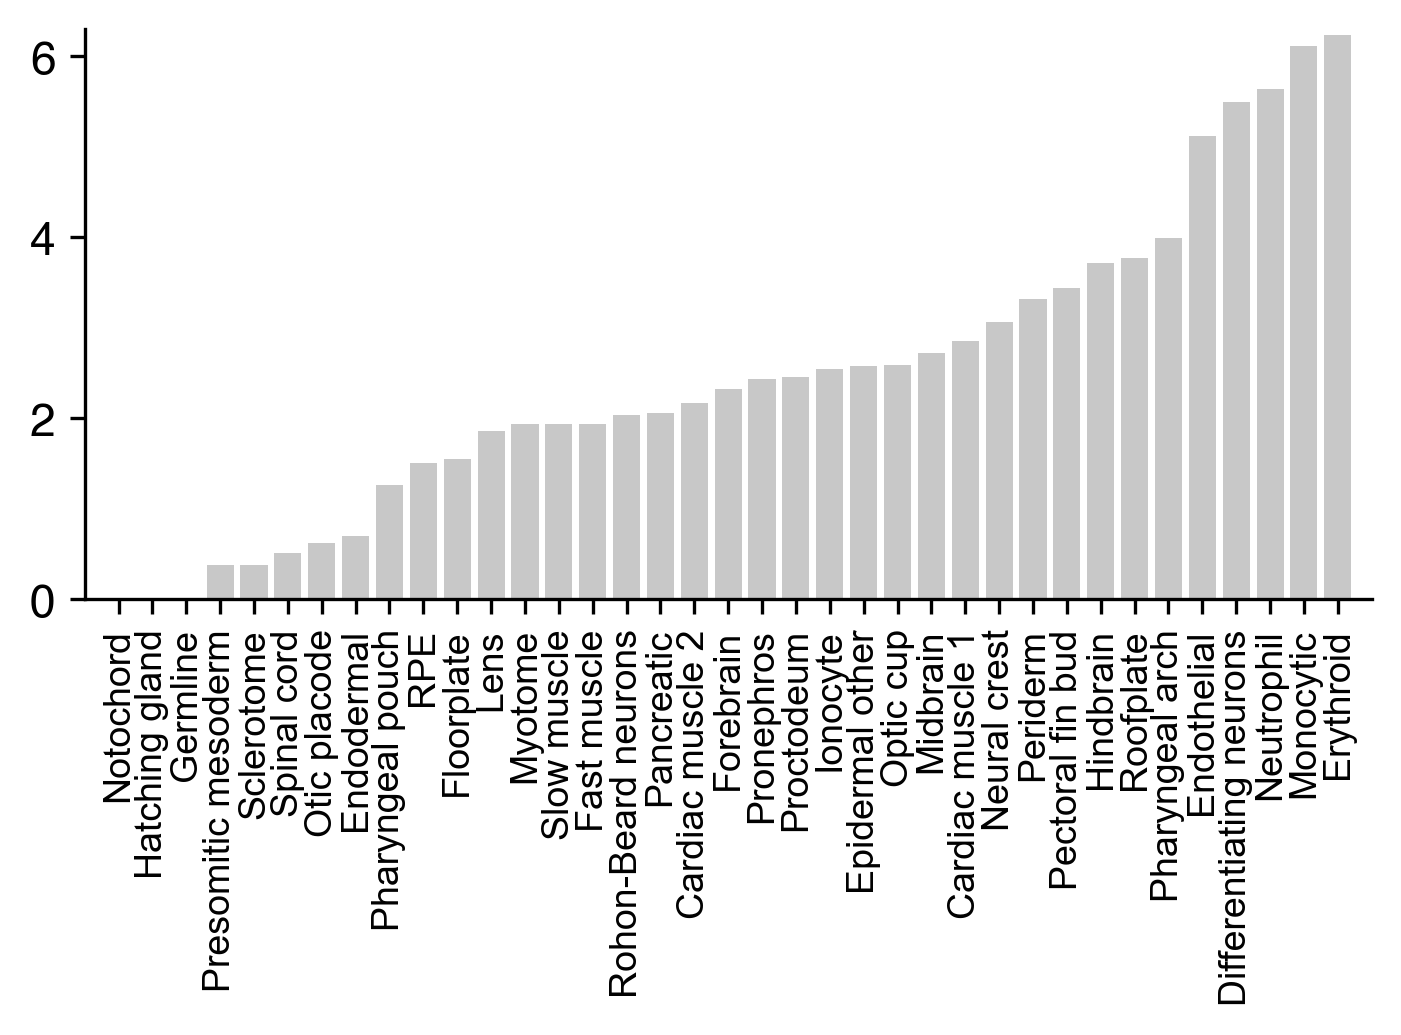

In [15]:
# plot proliferation scores:

pl.figure(figsize = (5.5,2.5))
pl.bar(np.arange(prolif24.shape[0]), np.log2(prolif24), color = '#C8C8C8')
pl.grid(False)
bla = pl.xticks(np.arange(prolif24.shape[0]), fontsize=9, labels = celltype_labels2, rotation = 90, fontname = 'Arial')
blu = pl.yticks(fontsize = 11, fontname = 'Helvetica')
sn.despine()
pl.ylim((0,6.3))
pl.xlim((-1,37))
pl.savefig("../../../figures/23-01-15_cell_divisions24_v2.pdf", bbox_inches='tight', dpi = 300)
#pl.savefig("../../figures/22-03-17_cell_divisions24.pdf", bbox_inches='tight', dpi = 300)


In [18]:
# get error bars for proliferation score:
'''
The idea is that you generate a whole new random data set by re-sampling each time point exactly once.
Then carry out all the calculations and get a “score” for each tissue at 24hpf. 
Then repeat 1000 times and get the standard deviation of the score.
'''

def get_cell_num_dict(fraction6,fraction8,fraction10,fraction14,fraction18,fraction24,total_cell_numbers):
    cell_num6 = {np.array(fraction6.index)[i]: 
             np.random.binomial(total_cell_numbers['6h'], fraction6)[i] for i in range(fraction6.shape[0])}
    cell_num8 = {np.array(fraction8.index)[i]: 
                 np.random.binomial(total_cell_numbers['8h'], fraction8)[i] for i in range(fraction8.shape[0])}
    cell_num10 = {np.array(fraction10.index)[i]: 
                 np.random.binomial(total_cell_numbers['10h'], fraction10)[i] for i in range(fraction10.shape[0])}
    cell_num14 = {np.array(fraction14.index)[i]: 
                 np.random.binomial(total_cell_numbers['14h'], fraction14)[i] for i in range(fraction14.shape[0])}
    cell_num18 = {np.array(fraction18.index)[i]: 
                 np.random.binomial(total_cell_numbers['18h'], fraction18)[i] for i in range(fraction18.shape[0])}
    cell_num24 = {np.array(fraction24.index)[i]: 
                 np.random.binomial(total_cell_numbers['24h'], fraction24)[i] for i in range(fraction24.shape[0])}
    cell_num_all = {**cell_num6, **cell_num8, **cell_num10, **cell_num14, **cell_num18, **cell_num24}
    
    return cell_num_all

def get_expansion(cell_number_dict, parent_daughter):

    edge_score = {}
    for p,d in parent_daughter.items():
        edge_score[p] = (np.array([cell_number_dict[states] for states in d]).sum())/cell_number_dict[p]
    
    prolif_score = {}
    for k in parent24_18dict.keys():
        edge18 = edge_score[parent24_18dict[k]]
        edge14 = edge_score[parent24_14dict[k]]
        edge10 = edge_score[parent24_10dict[k]]
        edge8  = edge_score[parent24_8dict[k]]
        edge6  = edge_score[parent24_6dict[k]]

        prolif_score[k] = edge18*edge14*edge10*edge8*edge6
        
    return prolif_score



In [19]:
n_iter = 1000
prolif_scores_for_err = np.zeros((fraction24.shape[0], n_iter))
for i in range(n_iter):
    cell_num = get_cell_num_dict(fraction6,fraction8,fraction10,fraction14,fraction18,fraction24,total_cell_numbers)
    prolif_scores_for_err[:,i] = np.array(pd.Series(get_expansion(cell_num, parent_daughter) ))
    

score_std = np.std(prolif_scores_for_err, axis = 1)

# note: the order of the scores is in the alphabetic order of states

In [20]:
score_std_pd = pd.DataFrame(pd.Series(score_std))
score_std_pd.index = fraction24.sort_index().index
score_std_pd.columns = ['standard deviation']

In [21]:
score_std_coarse = {}
for state in coarse_grain_rev_dict.keys():
    score_std_coarse[state] = np.sqrt((score_std_pd.loc[coarse_grain_rev_dict[state]]**2).sum())[0]

In [22]:
score_std_coarse_pd = ( pd.DataFrame(pd.Series(score_std_coarse))).sort_index()
score_std_coarse_pd.columns = ['standard deviation']


In [26]:
fit = np.polyfit(np.log2(prolif_score_coarse_pd['proliferation score']),
                 np.log2((total_cell_numbers['6h']/total_cell_numbers['24h'])*fc_hua['fc']) , deg =1 )



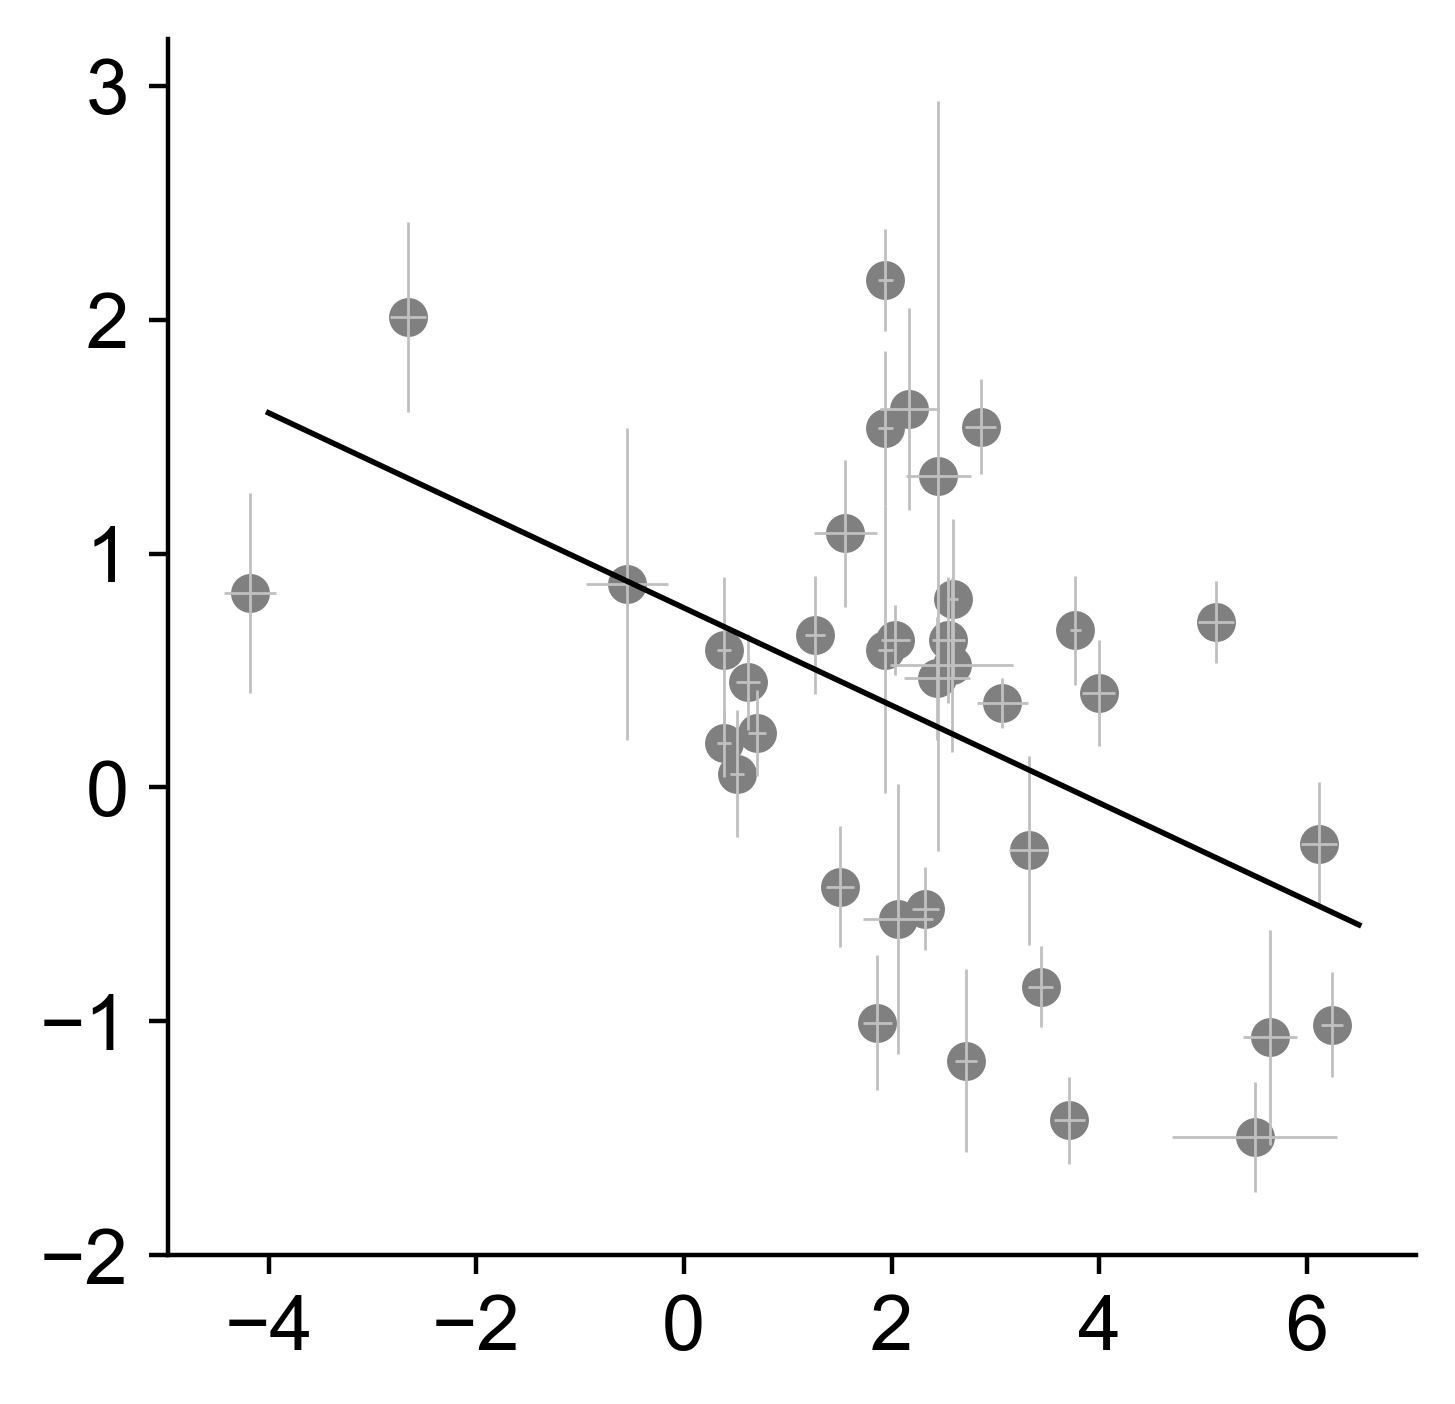

In [28]:
# plot score vs fold change abundance with error bars


pl.figure(figsize = (4,4),dpi = 200)

pl.scatter(np.log2(prolif_score_coarse_pd['proliferation score']),
           np.log2(fc_hua['fc']) , color = 'grey')



x_error = score_std_coarse_pd['standard deviation']/(np.log(2)*prolif_score_coarse_pd['proliferation score'])

pl.errorbar(x=np.log2(prolif_score_coarse_pd['proliferation score']), 
            y=np.log2(fc_hua['fc']), 
            xerr = x_error,
            yerr = np.array(sem_hua).T[0], 
            ls= 'none',elinewidth=0.5, ecolor='#C0C0C0', fmt = 'none',capthick = 0.5, color = None)




fit = np.polyfit(np.log2(prolif_score_coarse_pd['proliferation score']),
                 np.log2(fc_hua['fc']) , deg =1  )

x_line = np.arange(-4,6.6,0.1)
pl.plot(x_line, fit[0]*x_line + fit[1], color = 'black', linewidth = 1)


pl.grid(False)


#pl.xlim((-3,7))
pl.ylim((-2,3.2))
pl.xticks([-4,-2,0,2,4,6])
sn.despine()

pl.savefig("../../../figures/23-01-15_prolif_fc_hua_only_corr_iter2.pdf", bbox_inches='tight', dpi = 400)
#pl.xlabel('Inferred proliferation from 6 to 24hpf')
#pl.ylabel('log2 FC (HUA/control)')
